<a href="https://colab.research.google.com/github/DattaIn/idatta.github.io/blob/master/earthquake_analysis_from_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'earthquakes-alerts-tweets-dataset-daily-updated:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3318124%2F6054887%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240317%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240317T043052Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6cef29daabb096ab112ce09663c745ae94d088dd36cd0ec2d5b754339e1f7dc0e433246e59e83cbc4b021f82f6a9171ab525509420433f99be3e22126f2ec943b9c2f2797e7a4402f292bee562ce610c71a4c7d501863dd084f541ba83130d72ae221d6195a3d2436e9e52e8b5cced24449895e7848845598e33ce5d4556fb3b542b858d572b8dbb2496fe86806e33ec42701955aedaacfa0b841ab814a638d4546d4cfe62ca14139a3cc1bfb12d7f636390c8290ba0e5c44b482c9a1fa78e1b00119d3354329891a009c9822bfe7c368c2c2e32ca7d5fe8776c3b7244ad7e7ae25161c1a3c5d91c92d4bd8139211611b5702dd32a483c83d6ee9330f4610003'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 536772 bytes downloaded
Downloaded and uncompressed: earthquakes-alerts-tweets-dataset-daily-updated
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/earthquakes-alerts-tweets-dataset-daily-updated/QuakesToday.csv


In [3]:
import numpy as np                                                        # basic library to work with arrays
import pandas as pd                                                       # to read files
import seaborn as sns                                                     # library for statistical data visualization
import matplotlib.pyplot as plt                                           # basic library for plotting graphs and visualization
from matplotlib.colors import ListedColormap                              # for filling colors in mapping
from sklearn.metrics import confusion_matrix, accuracy_score              # importing confusion matrix, accuracy score
from sklearn.svm import SVC, SVR, LinearSVC                               # importing Support vector classifier, Support Vector Regressor, LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder            # preprocessing
from sklearn.model_selection import train_test_split                      # for splitting the dataset
from mlxtend.plotting import plot_decision_regions                        # to plot the decision boundaries and hyperplane
from sklearn.pipeline import make_pipeline                                # to import pipeline
from sklearn.linear_model import SGDClassifier                            # to import SGD Classifier

import spacy

In [4]:
dataset= pd.read_csv('/kaggle/input/earthquakes-alerts-tweets-dataset-daily-updated/QuakesToday.csv')
dataset.head()

,Datetime,Tweet Id,Text,Username
0,2023-06-29 20:27:03+00:00,1674514840549994498,2.0 magnitude #earthquake. 7 km from Enterpris...,QuakesToday
1,2023-06-29 20:04:03+00:00,1674509052423081985,"2.0 magnitude #earthquake. 3 km ESE of Egegik,...",QuakesToday
2,2023-06-29 20:01:04+00:00,1674508302087254017,2.2 magnitude #earthquake. 39 km from #Mentone...,QuakesToday
3,2023-06-29 20:01:04+00:00,1674508300061384704,"1.9 magnitude #earthquake. 20 km from Healy, #...",QuakesToday
4,2023-06-29 19:56:04+00:00,1674507042315472899,"2.4 magnitude #earthquake. 39 km from Mentone,...",QuakesToday


In [5]:
dataset.shape

(15496, 4)

In [ ]:
dataset.Text[2]

In [6]:
#create a new dataframe from the Texts. and associate DateTime column with the magnitude, earthquake, distance from a source, source name, state, country
import re

# Load the English language model for spaCy
#nlp = spacy.load('en_core_web_sm')

# Function to extract magnitude, distance, state, and country from text
def extract_info(text):

    # Finding parameters mentioned in the text
    #magnitude = None
    #distance = None
    #state = None
    #country = None

    # Define regular expressions for extracting magnitude, distance, source, state, and country
    #magnitude_pattern = r'(\d+\.\d+)\s+magnitude'
    #distance_pattern = r'(\d+)\s+km\s+from'
    #source_pattern = r'km\s+from\s+(\w+),\s+(\w+),'
    #state_country_pattern = r',\s+(\w+),\s+#(\w+)'

    # Extracting magnitude, distance, source, state, and country using regular expressions
    #magnitude_match = re.search(magnitude_pattern, text)
    #distance_match = re.search(distance_pattern, text)
    #source_match = re.search(source_pattern, text)
    #state_country_match = re.search(state_country_pattern, text)

    # Extracting values from matches
    #magnitude = float(magnitude_match.group(1)) if magnitude_match else None
    #distance = int(distance_match.group(1)) if distance_match else None
    #source = source_match.group(1) if source_match else None
    #state = state_country_match.group(1) if state_country_match else None
    #country = state_country_match.group(2) if state_country_match else None

    #-------------------------------------------------------------------------
    words = text.split()
    #print(len(words))
    magnitude = None
    distance = None
    source = None
    state = None
    country = None

    #'2.0 magnitude #earthquake. 7 km from Enterprise, NV, #UnitedStates https://t.co/P302bmZuGM'
    #'2.0 magnitude #earthquake. 3 km ESE of Egegik, Alaska https://t.co/sPv4wM2UZY'
    #'2.2 magnitude #earthquake. 39 km from #Mentone, TX, United States https://t.co/HNhLt5S2MB'

    try:
        magnitude = float(words[0])
        distance = float(words[3])
        source = words[5].lstrip('#').rstrip(',') if words[5] != 'from' else words[6].lstrip('#').rstrip(',')
        state = words[7].lstrip('#').rstrip(',')
        country = words[8].lstrip('#')
    except:
        return None, None, None, None, None

    # Print the extracted values
    #print(f'Magnitude: {magnitude}')
    #print(f'Distance: {distance}')
    #print(f'Source: {source}')
    #print(f'State: {state}')
    #print(f'Country: {country}')


    return magnitude, distance, source, state, country


#extract_info(dataset['Text'][2])

# Create dataframe
# Apply extraction function to each row in the dataframe
dataset['Magnitude'], dataset['Distance_from_source_km'], dataset['Source'], dataset['State'], dataset['Country'] = \
    zip(*dataset['Text'].apply(extract_info))

# Create new dataframe with extracted information
df_texts = dataset[['Datetime', 'Magnitude', 'Distance_from_source_km', 'Source', 'State', 'Country']]

print(df_texts)
print(df_texts.shape)

                        Datetime  Magnitude  Distance_from_source_km  \
0      2023-06-29 20:27:03+00:00        2.0                      7.0   
1      2023-06-29 20:04:03+00:00        2.0                      3.0   
2      2023-06-29 20:01:04+00:00        2.2                     39.0   
3      2023-06-29 20:01:04+00:00        1.9                     20.0   
4      2023-06-29 19:56:04+00:00        2.4                     39.0   
...                          ...        ...                      ...   
15491  2023-02-16 22:08:02+00:00        1.7                     52.0   
15492  2023-02-16 22:06:03+00:00        3.0                     41.0   
15493  2023-02-16 21:53:03+00:00        NaN                      NaN   
15494  2023-02-16 21:39:03+00:00        2.1                      3.0   
15495  2023-02-16 21:17:03+00:00        1.9                      4.0   

             Source   State       Country  
0        Enterprise      NV  UnitedStates  
1               ESE  Egegik        Alaska  
2  

In [7]:
df_texts = df_texts.dropna()
print(df_texts.shape)

(14423, 6)


In [ ]:
df_texts.head(100)

In [ ]:
# Initialize LabelEncoder
encoder = LabelEncoder()
# Encode categorical columns
df_texts['Source_encoded'] = encoder.fit_transform(df_texts['Source'])
df_texts['State_encoded'] = encoder.fit_transform(df_texts['State'])
df_texts['Country_encoded'] = encoder.fit_transform(df_texts['Country'])
df_texts.head()

In [ ]:
#understand distribution of magnitude in a magnitude column of a dataframe. This will help to make the column discrete values
#which is currently type of continuous value. This will help to use SVD as svd accepts only discrete values in target variables.

import matplotlib.pyplot as plt

# Plot histogram for magnitude
plt.hist(df_texts['Magnitude'], bins=10, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of magnitude')
plt.show()


In [ ]:
#From the above values, we need to use floor and check again
df_magnitude = df_texts['Magnitude']
df_magnitude = df_magnitude.apply(np.ceil)

# Plot histogram for magnitude
plt.hist(df_magnitude, bins=10, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of magnitude')
plt.show()

In [ ]:
#Assuming the magnitude values currently to it ceiling from the above result
df_magnitude.head()

In [ ]:
df_texts['Magnitude'] = df_magnitude

In [ ]:
# defining the independent and dependent variable
x = df_texts.iloc[:, [2, 6, 7, 8]].values
y = df_texts.iloc[:, 1].values

print(x)
print(y[:5])

In [ ]:
# using train test split, splitting the dataset into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.25, random_state=0)

In [ ]:
# Scaling the data
st_x = StandardScaler()
#st_y = StandardScaler()
x_train = st_x.fit_transform(x_train)
x_test = st_x.transform(x_test)

In [ ]:
# kernel = 'linear' is used on data which is separable
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(x_train, y_train)

In [ ]:
# Make a pipeline of Scaling and SVM
clf = make_pipeline(StandardScaler(),
                     LinearSVC(random_state=0, tol=1e-5, max_iter=10000))
clf.fit(x_train, y_train)

In [ ]:
# predicting using SVC with kernel='Linear'
y_pred = classifier.predict(x_test)
print("predicted values ",y_pred)

In [ ]:
# Compute evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

In [ ]:
# Using SGD Classifier

# Always scale the input. The most convenient way is to use a pipeline.
clf2 = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=10000, tol=1e-3, loss="hinge"))
clf2.fit(x_train, y_train)

In [ ]:
# predicting results using SGD Classifier
y_pred2 = clf2.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

****Another Approach****
****We need to see if any of the predictors has a relationship with the others****

In [ ]:
# Specify the column names of your predictors
predictors = ['Distance_from_source_km', 'Source_encoded', 'State_encoded', 'Country_encoded']

# Calculate the correlation matrix
correlation_matrix = df_texts[predictors].corr()

# Print or visualize the correlation matrix
print(correlation_matrix)

# Plot the correlation matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Predictors')
plt.ylabel('Predictors')
plt.show()

**From the coorelation matrix above it can be said that the predictors are not biased**

# TIME SERIES ANALYSIS

In [9]:
from IPython import get_ipython

ipython = get_ipython()
ipython.magic("sx pip -q install astsadata")

['\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/473.8 kB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b112.6/473.8 kB\x1b \x1b3.2 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b473.8/473.8 kB\x1b \x1b6.8 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25h']

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from astsadata import globtemp, jj, speech, EQ5, EXP6, soi, rec

/usr/local/lib/python3.10/dist-packages/astsadata/astsadata.py:36: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cmort.index = cmort.index.to_period("W")
/usr/local/lib/python3.10/dist-packages/astsadata/astsadata.py:61: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  gas.index = gas.index.to_period("W")
/usr/local/lib/python3.10/dist-packages/astsadata/astsadata.py:97: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  lap.index = lap.index.to_period("W")
/usr/local/lib/python3.10/dist-packages/astsadata/astsadata.py:109: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  oil.index = oil.index.to_period("W")
/usr/local/lib/python3.10/dist-packages/astsadata/astsadata.py:112: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  part.index = part.index.to_period("W")
/u

In [15]:
# Extract date, time, week, month, and year into separate columns
df_texts['Datetime'] = pd.to_datetime(df_texts['Datetime'])
df_texts['date'] = df_texts['Datetime'].dt.date
df_texts['time'] = df_texts['Datetime'].dt.time
df_texts['week'] = df_texts['Datetime'].dt.week
df_texts['month'] = df_texts['Datetime'].dt.month
df_texts['year'] = df_texts['Datetime'].dt.year

df_texts.head()

<ipython-input-15-b3819e715da7>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_texts['week'] = df_texts['Datetime'].dt.week


,Datetime,Magnitude,Distance_from_source_km,Source,State,Country,date,time,week,month,year
0,2023-06-29 20:27:03+00:00,2.0,7.0,Enterprise,NV,UnitedStates,2023-06-29,20:27:03,26,6,2023
1,2023-06-29 20:04:03+00:00,2.0,3.0,ESE,Egegik,Alaska,2023-06-29,20:04:03,26,6,2023
2,2023-06-29 20:01:04+00:00,2.2,39.0,Mentone,TX,United,2023-06-29,20:01:04,26,6,2023
3,2023-06-29 20:01:04+00:00,1.9,20.0,Healy,AK,United,2023-06-29,20:01:04,26,6,2023
4,2023-06-29 19:56:04+00:00,2.4,39.0,Mentone,TX,United,2023-06-29,19:56:04,26,6,2023


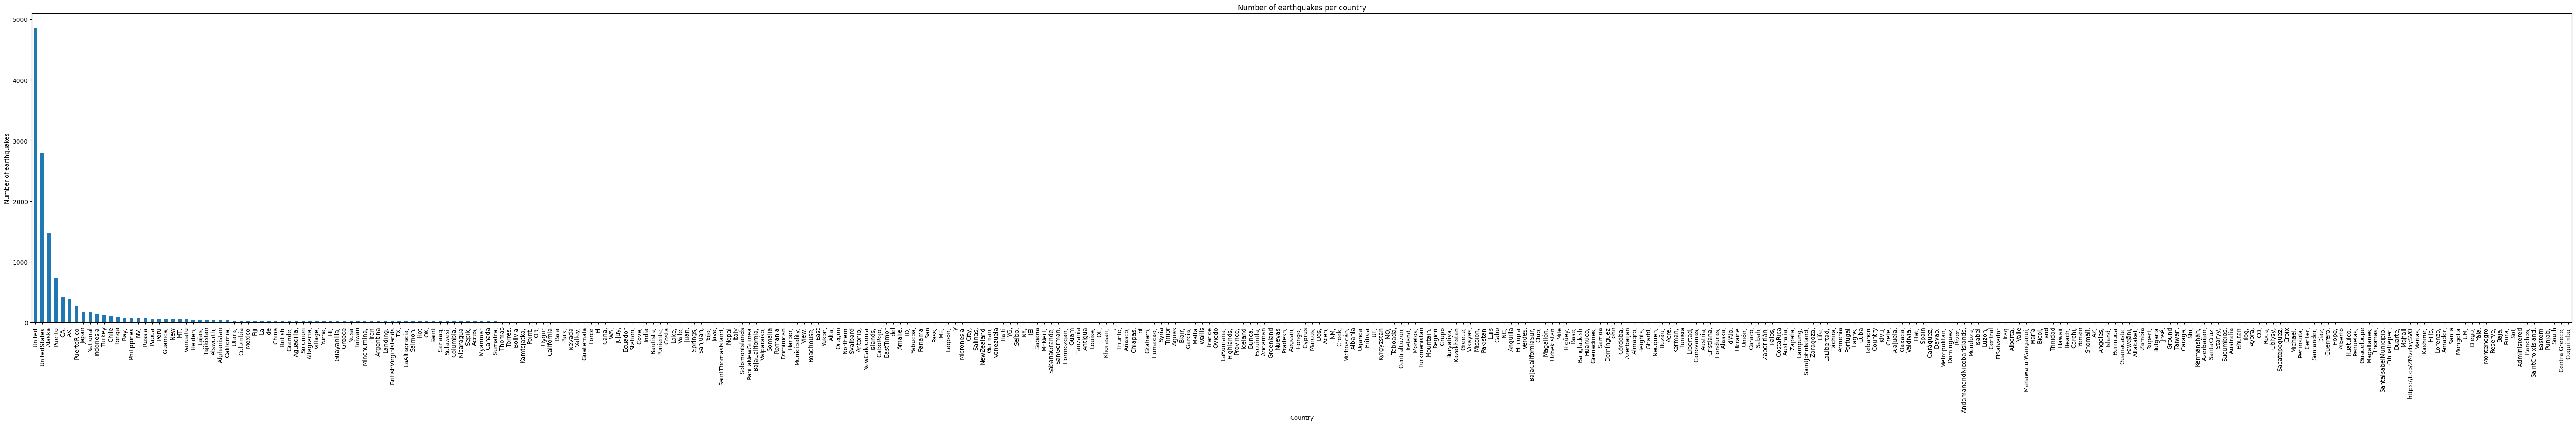

In [48]:
# @title Number of earthquakes per country
import matplotlib.pyplot as plt


# Set the figure size and create a subplot
fig, ax = plt.subplots(figsize=(60, 10))  # Increase the figure size to increase the y-axis length

df_texts['Country'].value_counts().plot(kind='bar', ax=ax)
ax.set_xlabel('Country')
ax.set_ylabel('Number of earthquakes')
_ = ax.set_title('Number of earthquakes per country')
# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

From the plot it can be seen US has maximum number of earthquakes as per data

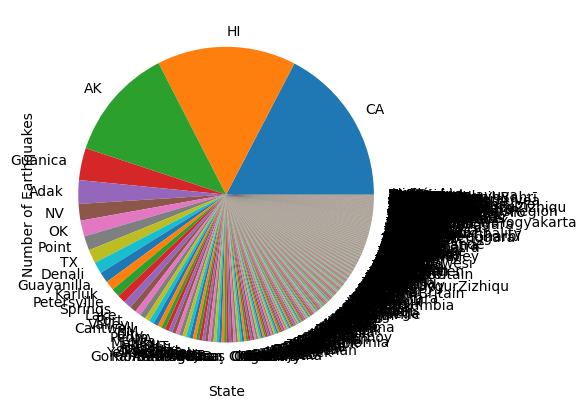

In [28]:
# @title Earthquake Count by State

import matplotlib.pyplot as plt
df_texts['State'].value_counts().plot(kind='pie')
plt.xlabel('State')
_ = plt.ylabel('Number of Earthquakes')

# AK is the code for Alaska, CA is the code for California, and HI is the code for Hawaii. They are most prone to earthquakes

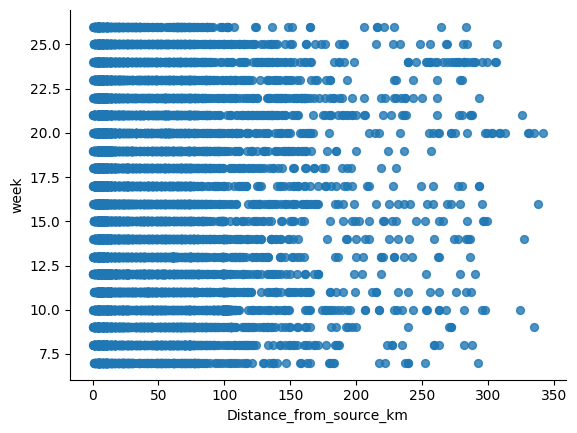

In [27]:
# @title Distance_from_source_km vs week

from matplotlib import pyplot as plt
df_texts.plot(kind='scatter', x='Distance_from_source_km', y='week', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

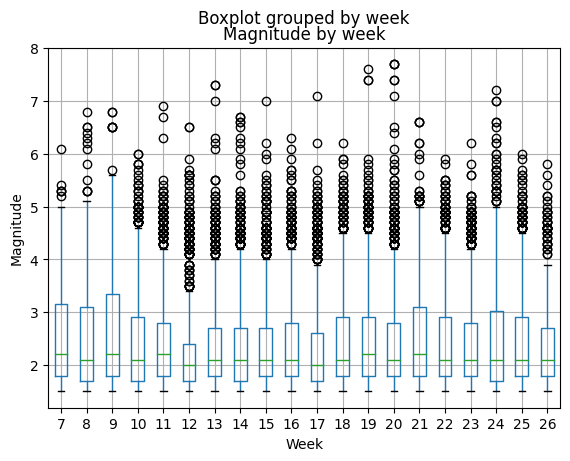

In [24]:
# @title Magnitude by week

import matplotlib.pyplot as plt
df_texts.boxplot(column='Magnitude', by='week')
plt.xlabel('Week')
plt.ylabel('Magnitude')
_ = plt.title('Magnitude by week')

It can be concluded from the above that in the weeks of 11, 13, 15, 17, 19, 20, 24th the magnitude of earchquake reaches more than 7

In [26]:
# Define a dictionary to map weeks to month names
week_to_month_name = {
    11: 'March', # 4(weeks)*3(3rd month of the year) = 12
    13: 'April', # 4*4 = 16
    15: 'April', #
    17: 'May',
    19: 'May',
    20: 'May',
    24: 'June'  # Week 24 corresponds to June
}

# Given weeks
weeks = [11, 13, 15, 17, 19, 20, 24]

# Convert weeks to month names
months_names = [week_to_month_name[week] for week in weeks]

# Print the converted month names
print('Months on which Magnitudes of the earthquake was highest:', months_names)

Months on which Magnitudes of the earthquake was highest: ['March', 'April', 'April', 'May', 'May', 'May', 'June']


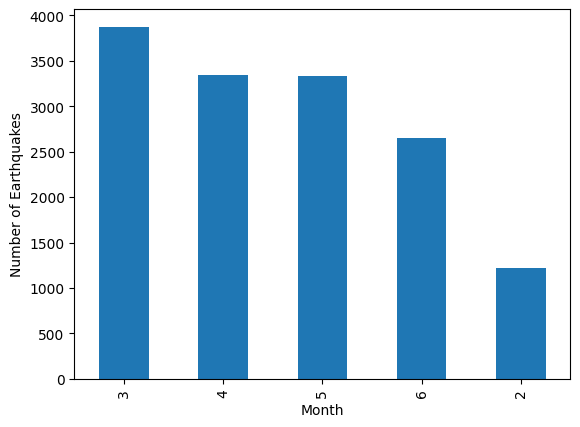

In [23]:
# @title Earthquakes per Month

import matplotlib.pyplot as plt
df_texts['month'].value_counts().plot(kind='bar')
plt.xlabel('Month')
_ = plt.ylabel('Number of Earthquakes')

It can be concluded from the above that in the month of March earthquake happened most and February month it is very less

<Axes: xlabel='Magnitude', ylabel='Distance_from_source_km'>

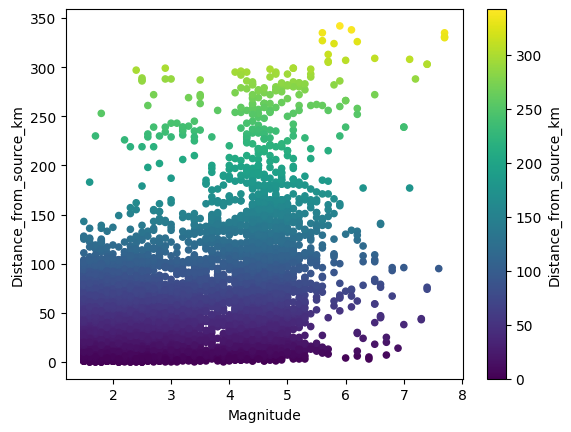

In [22]:
# @title Magnitude vs Distance from Source

df_texts.plot(kind='scatter', x='Magnitude', y='Distance_from_source_km', c='Distance_from_source_km', colormap='viridis')

It can be concluded from the above visualization that till 350 km the magnitude of the earthquake can reach upto 8

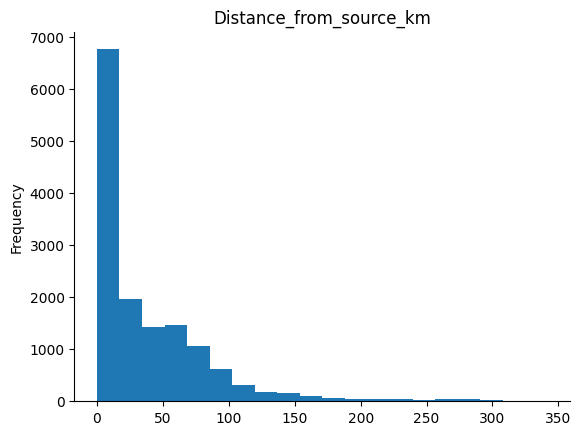

In [21]:
# @title Distance_from_source_km

from matplotlib import pyplot as plt
df_texts['Distance_from_source_km'].plot(kind='hist', bins=20, title='Distance_from_source_km')
plt.gca().spines[['top', 'right',]].set_visible(False)

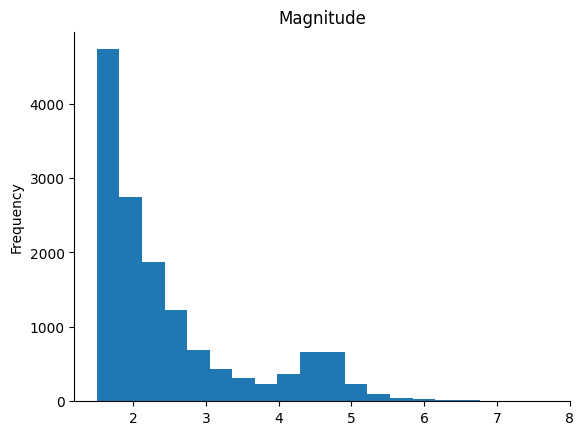

In [20]:
# @title Magnitude

from matplotlib import pyplot as plt
df_texts['Magnitude'].plot(kind='hist', bins=20, title='Magnitude')
plt.gca().spines[['top', 'right',]].set_visible(False)

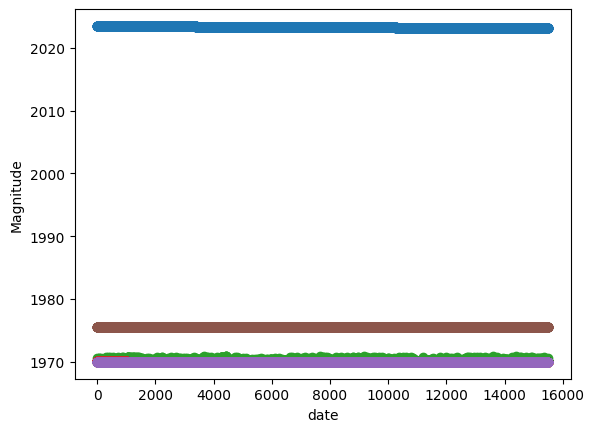

In [16]:
# Visualize yearly average global temperature deviations
df_texts.plot(xlabel='date', ylabel='Magnitude', marker='o', legend=False)
plt.show()

In [19]:
df_texts['year'].unique()

array([2023])

From the above plot it is sure that we need to get details indivudually in 1970, 1980, 2023